In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
import seaborn as sns
from stimuli import staircase

In [242]:
def phi_j_t(X, j, t, t_val, tau_val):
    '''
    evoked potential for neuron j at time t
    '''
    cumulative_time_array = np.arange(0, tt + 1) / 1000.
    phi = np.dot(np.exp(-(t_val - cumulative_time_array) / tau_val), X[j, :tt + 1])
    return phi

def phi_t(X, t, t_val, tau_val):
    '''
    summed evoked potentials across all neurons at time t
    '''
    cumulative_time_array = np.arange(0, t + 1) / 1000.
    phi = np.dot(np.exp(-(t_val - cumulative_time_array) / tau_val), X[:, :t + 1].transpose())
    return phi


def eta_i_t(X, i, t, t_val, tau_val, eta_0):
    '''
    adaptation potential of neuron i at time t
    '''
    cumulative_time_array = np.arange(0, tt + 1) / 1000.
    phi = np.dot(np.exp(-(t_val - cumulative_time_array) / tau_val), X[i, :tt + 1])
    return -eta_0 * phi


def rho_i_t(u, i, t, v, delta_u):
    '''
    firint rate of neuron i at time t
    '''
    return rho_0 * np.exp((u[i, t] - v) / delta_u)


def log_likelihood(X, u):
    '''
    compute log likelihood of current model
    '''
    likelihoods = []
    for ii in range(num_neurons):
        
        for tt in range(num_timebins):
            
            curr_rho = rho_i_t(u=u, v=v, delta_u=delta_u, i=ii, t=tt)
            curr_x = X[ii, tt]
            
            curr_likelihood = np.log(curr_rho) * curr_x - curr_rho
            likelihoods.append(curr_likelihood)
            
    return np.sum(likelihoods)

def update_membrane_potential(X, tt, ii, tau_val1, tau_val2, weights):
    
#     t_val = t / 1000.
    
#     cumulative_time_array = np.arange(0, t + 1) / 1000.
#     phi_unscaled = phi_t(X=X, t=t, t_val=t_val, tau_val=tau_val1)
#     phi = np.dot(weights[i, :], phi_unscaled)

#     eta = eta_i_t(X=X, tau_val=tau_val2, t=t, t_val=t_val, i=i, eta_0=eta_0)
    
#     return phi + eta

    tt_val = tt / 1000.
            
    ## loop over neurons
    cumulative_time_array = np.arange(0, tt + 1) / 1000.
    phi_unscaled = phi_t(X=X, t=tt, t_val=tt_val, tau_val=tau)
    phi = np.dot(weights[ii, :], phi_unscaled)

    eta = eta_i_t(X=X, tau_val=tau_adapt, t=tt, t_val=tt_val, i=ii, eta_0=eta_0)
    
    return phi + eta


def visible_weight_gradient(X, ii, jj, tau_val, u):
    #timebin_summands = []
#     for tt in range(num_timebins):

#         tt_val = tt / 1000.

#         curr_phi_j_t = phi_j_t(X=X, j=j, t=tt, t_val=tt_val, tau_val=tau_val)

#         x_minus_rho = X[ii, tt] - rho_i_t(u=u, v=v, t=tt, i=i, delta_u=delta_u)

#         summand = curr_phi_j_t * x_minus_rho
#         timebin_summands.append(summand)

#     weight_gradient = np.sum(timebin_summands)
#     return weight_gradient

    timebin_summands = []
    for tt in range(num_timebins):

        tt_val = tt / 1000.

        curr_phi_j_t = phi_j_t(X=data, j=jj, t=tt, t_val=tt_val, tau_val=tau)

        x_minus_rho = data[ii, tt] - rho_i_t(u=potentials, v=v, t=tt, i=ii, delta_u=delta_u)

        summand = curr_phi_j_t * x_minus_rho
        timebin_summands.append(summand)

    weight_gradient = np.sum(timebin_summands)
    return weight_gradient



In [424]:
num_neurons = 15
num_timebins = 100
num_iter = 50
print_iter = 10

tau = 0.01
eta_0 = 0.1
tau_adapt = 0.01
rho_0 = 1
v = 0
delta_u = 1
mu_M = 0.1
mu_Q = 0.00001
tau_G = 0.01
tau_baseline = 0.1
dt = 0.001

## Generate synthetic data
data = np.random.binomial(n = 1, p = 0.1, size = [num_neurons, num_timebins])
true_weights = np.random.normal(loc=0, scale=0.1, size = [num_neurons, num_neurons]) # not used currently, but one could do a simulation to see if the true weights are recovered




In [480]:
## Simulate data from random weights

simulated_potentials = np.zeros((num_neurons, num_timebins))
firing_intensities = np.zeros((num_neurons, num_timebins))
simulated_potentials[:, 0] = np.random.normal(loc=0, scale=0.01, size = num_neurons)
data = np.zeros((num_neurons, num_timebins))

for ii in range(num_neurons):
    firing_intens = rho_0 * np.exp((simulated_potentials[ii, 0] - v) / delta_u)
    data[ii, 0] = min(np.random.poisson(firing_intens), 1)
    
for tt in range(1, num_timebins):
    
    tt_val = tt / 1000.
    
    for ii in range(num_neurons):
        
        phi_j_t_list = []
        
        
        for jj in range(num_neurons):
            
#             cumulative_time_array = (np.arange(0, tt) + 1) / 1000.
            
#             phi_j_t = np.dot(np.exp(-(tt_val - cumulative_time_array - 1) / tau), data[jj, :tt])
            
            phi_j_t = []
            for ttsub in range(tt):
                ttsub_val = ttsub / 1000.
                phi_j_ttsub = np.exp(-(tt_val - ttsub_val - dt) / tau) * data[jj, ttsub] * dt
                phi_j_t.append(phi_j_ttsub)
                
            phi_j_t = np.sum(phi_j_t)
            phi_j_t_list.append(phi_j_t)
    
#         cumulative_time_array = (np.arange(0, tt) + 1) / 1000.
#         eta_i_t = np.dot(np.exp(-(tt - cumulative_time_array - 1) / tau_adapt), data[ii, :tt])
            
        eta_i_t = []
        for ttsub in range(tt):
            ttsub_val = ttsub / 1000.
            eta_i_ttsub = np.exp(-(tt_val - ttsub_val - dt) / tau_adapt) * data[ii, ttsub] * dt
            eta_i_t.append(eta_i_ttsub)
        
        eta_i_t = -eta_0 * np.sum(eta_i_t)
#         eta_i_t = -eta_0 * eta_i_t
            
        u_i_t = np.dot(true_weights[ii, :], np.array(phi_j_t_list)) + eta_i_t
        simulated_potentials[ii, tt] = u_i_t
        
        
        firing_intensity = rho_0 * np.exp((u_i_t - v) / delta_u)
        firing_intensities[ii, tt] = firing_intensity
        num_spikes = np.random.poisson(firing_intensity)
        
        data[ii, tt] = min(num_spikes, 1)
        
        
        
            
    
# loop over time bins
# for tt in range(1, num_timebins):
    
#     ## loop over neurons
#     potential_list = []
#     for jj in range(num_neurons):

#         cumulative_time_array = (np.arange(0, tt) + 1) / 1000.
#         phi = np.dot(np.exp(-(tt_val - cumulative_time_array) / tau), data[jj, :tt]) * dt

#         potential_list.append(phi)

#     potential_list = np.array(potential_list)
    
#     for ii in range(num_neurons):
        
#         tt_val = tt / 1000.
    
#         cumulative_time_array = (np.arange(0, tt) + 1) / 1000.
#         curr_eta = -eta_0 * np.dot(np.exp(-(tt - cumulative_time_array) / tau_adapt), data[ii, :tt]) * dt
#         simulated_potentials[ii, tt] = np.dot(true_weights[ii, :], potential_list) + curr_eta
    
#         firing_intens = rho_0 * np.exp((simulated_potentials[ii, tt] - v) / delta_u)
#         firing_intensities[ii, tt] = firing_intens
#         data[ii, tt] = min(np.random.poisson(firing_intens), 1)
        



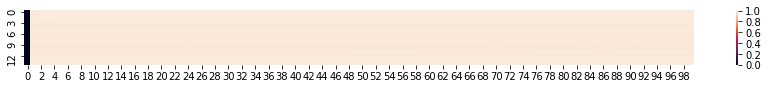

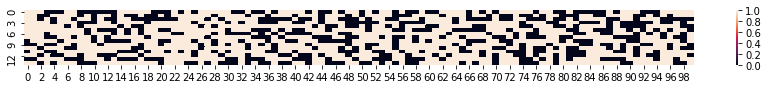

In [481]:
fig, ax = plt.subplots(figsize=(15,1))  
sns.heatmap(firing_intensities)

fig, ax = plt.subplots(figsize=(15,1))  
sns.heatmap(data)

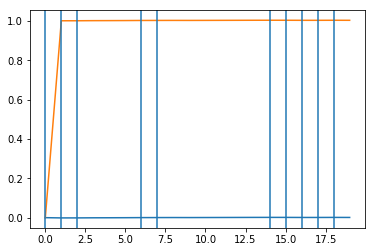

In [482]:
neuron_num = 0
start_idx = 0
sess_length = 20
end_idx = start_idx + sess_length
plt.plot(simulated_potentials[neuron_num, start_idx:end_idx])
plt.plot(firing_intensities[neuron_num, start_idx:end_idx])
spike_times = data[neuron_num, start_idx:end_idx] > 0
xcoords = np.arange(sess_length)[spike_times] * 1.0
for i in xcoords:
    plt.axvline(x=i)

In [437]:
learned_weights = np.random.normal(loc=0, scale=0.1, size = [num_neurons, num_neurons])

## Initialize arrays
potentials = np.zeros((num_neurons, num_timebins))

In [438]:
likelihood_trace = []
mse_trace = []
for iter_num in range(num_iter):
    
    ## Update membrane potential
    for ii in range(num_neurons):
        
        # loop over time bins
        for tt in range(num_timebins):
            
            tt_val = tt / 1000.
            
            ## loop over neurons
            cumulative_time_array = np.arange(0, tt + 1) / 1000.
            phi_unscaled = phi_t(X=data, t=tt, t_val=tt_val, tau_val=tau)
            phi = np.dot(learned_weights[ii, :], phi_unscaled) * dt
            
            eta = eta_i_t(X=data, tau_val=tau_adapt, t=tt, t_val=tt_val, i=ii, eta_0=eta_0)
            potentials[ii, tt] = phi + eta
            
#             potential_update = update_membrane_potential(X=data, tt=tt, ii=ii, tau_val1=tau, tau_val2=tau_adapt, weights=learned_weights)

#             potentials[ii, tt] = potential_update
            
    
#     for tt in range(0, num_timebins):
    
#         ## loop over neurons
#         potential_list = []
#         for jj in range(num_neurons):

#             cumulative_time_array = (np.arange(0, tt) + 1) / 1000.
#             phi = np.dot(np.exp(-(tt_val - cumulative_time_array) / tau), data[jj, :tt])

#             potential_list.append(phi)

#         potential_list = np.array(potential_list)


#         ## Simulate membrane potential
#         for ii in range(num_neurons):

#             tt_val = tt / 1000.

#             cumulative_time_array = (np.arange(0, tt) + 1) / 1000.
#             curr_eta = -eta_0 * np.dot(np.exp(-(tt - cumulative_time_array) / tau_adapt), data[ii, :tt])
#             potentials[ii, tt] = np.dot(learned_weights[ii, :], potential_list) + curr_eta
            
    ## Update weights
    for ii in range(num_neurons):
        for jj in range(num_neurons):
        
            ## loop over time bins
            timebin_summands = []
            for tt in range(num_timebins):
                
                tt_val = tt / 1000.
                
#                 curr_phi_j_t = phi_j_t(X=data, j=jj, t=tt, t_val=tt_val, tau_val=tau)

                cumulative_time_array = (np.arange(0, tt) + 1) / 1000.
                curr_phi_j_t = np.dot(np.exp(-(tt_val - cumulative_time_array) / tau), data[jj, :tt]) * dt
                                
                x_minus_rho = data[ii, tt] - rho_i_t(u=potentials, v=v, t=tt, i=ii, delta_u=delta_u) * dt
        
                summand = curr_phi_j_t * x_minus_rho
                timebin_summands.append(summand)
                
            weight_gradient = np.sum(timebin_summands)
            learned_weights[ii, jj] += mu_M * weight_gradient
            
#             M_weight_gradient = visible_weight_gradient(X=data, ii=ii, jj=jj, tau_val=tau, u=potentials)
#             learned_weights[ii, jj] += mu_M * M_weight_gradient

            
     
    # print and save likelihoods over time
    if iter_num % 1 == 0:
        curr_likelihood = log_likelihood(u=potentials, X=data)
        likelihood_trace.append(curr_likelihood)
        
        curr_mse = np.mean((learned_weights - true_weights)**2)
        mse_trace.append(curr_mse)
        print 'Likelihood: {}, MSE: {}'.format(curr_likelihood, curr_mse)

TypeError: 'numpy.float64' object is not callable

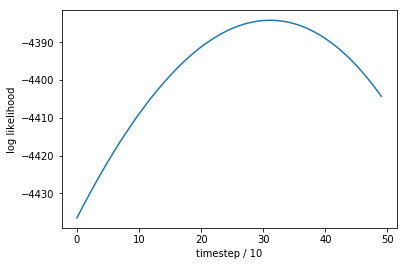

In [347]:
plt.plot(likelihood_trace)
plt.xlabel("timestep / {}".format(print_iter))
plt.ylabel("log likelihood")
plt.show()

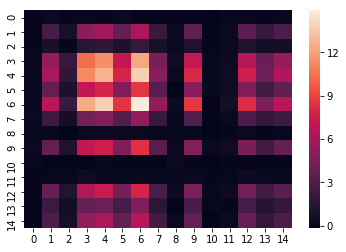

In [340]:
sns.heatmap(learned_weights)

In [341]:
## Generate data from learned weights

simulated_potentials = np.zeros((num_neurons, num_timebins))
    
## Simulate membrane potential
for ii in range(num_neurons):

    # loop over time bins
    for tt in range(num_timebins):

        tt_val = tt / 1000.

        ## loop over neurons
        potential_list = []
        for jj in range(num_neurons):

            curr_weight = learned_weights[ii, jj] * phi_j_t(X=data, j=jj, t=tt, t_val=tt_val, tau_val=tau)
            potential_list.append(curr_weight)

        simulated_potentials[ii, tt] = np.sum(potential_list) + eta_i_t(X=data, tau_val=tau_adapt, t=tt, t_val=tt_val, i=ii, eta_0=eta_0)

In [342]:
poisson_rates = np.zeros((num_neurons, num_timebins))
for ii in range(num_neurons):
    for tt in range(num_timebins):
        poisson_rates[ii, tt] = rho_i_t(delta_u=delta_u, i=ii, t=tt, u=simulated_potentials, v=v)


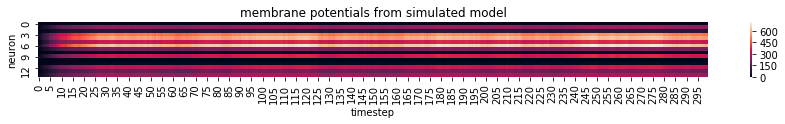

In [343]:
fig, ax = plt.subplots(figsize=(15,1))
sns.heatmap(simulated_potentials)
plt.xlabel("timestep")
plt.ylabel("neuron")
plt.title("membrane potentials from simulated model")
plt.show()

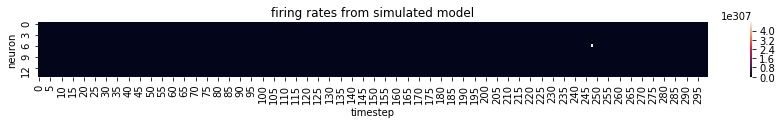

In [344]:
fig, ax = plt.subplots(figsize=(15,1))
sns.heatmap(poisson_rates)
plt.xlabel("timestep")
plt.ylabel("neuron")
plt.title("firing rates from simulated model")
plt.show()

In [345]:
simulated_spikes = np.random.poisson(lam=poisson_rates)
fig, ax = plt.subplots(figsize=(15,1))
sns.heatmap((simulated_spikes >= 1).astype(int))
plt.xlabel("timestep")
plt.ylabel("neuron")
plt.title("spikes from simulated model")
plt.show()
plt.show()

ValueError: lam value too large.

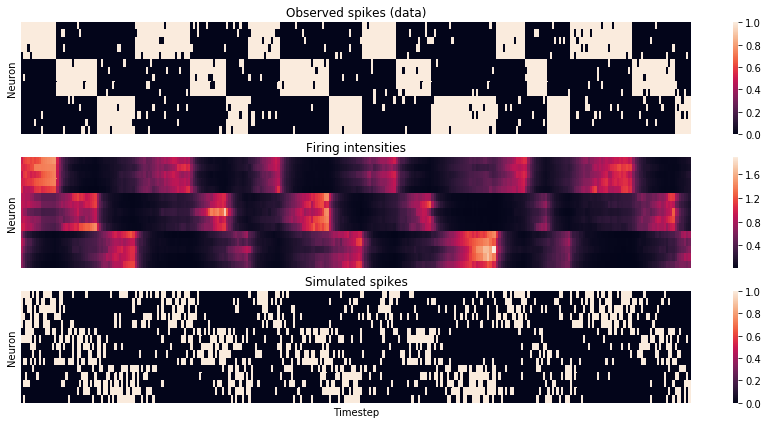

In [332]:
fig, ax = plt.subplots(figsize=(15,7))
plt.subplot(3, 1, 1)
sns.heatmap(data, xticklabels=False, yticklabels=False)
plt.title("Observed spikes (data)")
plt.ylabel("Neuron")
plt.subplot(3, 1, 2)
sns.heatmap(poisson_rates, xticklabels=False, yticklabels=False)
plt.title("Firing intensities")
plt.ylabel("Neuron")
plt.subplot(3, 1, 3)
sns.heatmap((simulated_spikes >= 1).astype(int), xticklabels=False, yticklabels=False)
plt.title("Simulated spikes")
plt.xlabel("Timestep")
plt.ylabel("Neuron")
plt.savefig("/Users/andrewjones/Documents/pillow_lab/variational_spiking_networks/plots/simulated_model_visible_only.png")
plt.show()

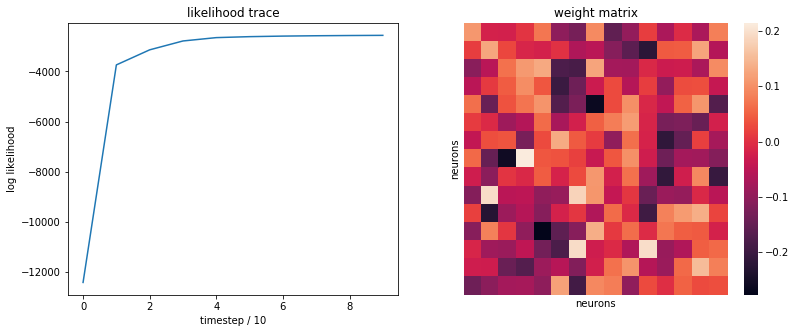

In [340]:
fig, ax = plt.subplots(figsize=(13, 5))
plt.subplot(1, 2, 1)

plt.plot(likelihood_trace)
plt.xlabel("timestep / {}".format(print_iter))
plt.ylabel("log likelihood")
plt.title("likelihood trace")

plt.subplot(1, 2, 2)

sns.heatmap(learned_weights, xticklabels=False, yticklabels=False)
plt.xlabel("neurons")
plt.ylabel("neurons")
plt.title("weight matrix")

plt.savefig("/Users/andrewjones/Documents/pillow_lab/variational_spiking_networks/plots/trained_model_weights_and_likelihood_visible_only.png")
plt.show()